El objetivo de el trabajo es descubrir si hay una releación entre el precio del GNC y el precio de los materiales de construcción en Rosario. La hipótesis es que a medida que aumente el precio del GNC aumentaran los gastos de transporte por lo que también aumentaran los precios de los materiales.

Para analizar esto se tomaron datos desde enero de 2019 hasta abril del 2023.

# Exploración de datos

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Los datasets se obutiveron de las siguientes fuentes:
- [Precios gas natural](http://datos.energia.gob.ar/dataset/precios-de-gas-natural)
- [Precios materiales](https://datosabiertos.rosario.gob.ar/dataset/%C3%ADndices-de-precios-de-materiales-de-la-construcci%C3%B3n)

In [3]:
precios_gas        = pd.read_csv('datasets/precios-gas-natural.csv')
precios_materiales = pd.read_csv('datasets/precios-materiales-construccion.csv')

In [4]:
precios_materiales.rename(
    columns={
        'Año': 'anio',
        'Mes': 'mes',
        'id_Rubro': 'id_rubro',
        'Rubro': 'rubro',
        'variación mensual': 'variacion_mensual'
    },
    inplace=True
)   

Solo se van a analizar el total de los precios, sin importar el tipo de contrato

In [5]:
precios_gas = \
    precios_gas[precios_gas.contrato == 'TOTAL']

Se separa por cuenca.

In [6]:
santa_cruz = precios_gas[precios_gas.cuenca == 'Austral Santa Cruz']
santa_cruz.Name = 'Austral Santa Cruz'

tierra_del_fuego = precios_gas[precios_gas.cuenca == 'Austral Tierra del Fuego']
tierra_del_fuego.Name = 'Austral tierra del Fuego'

golfo_san_jorge = precios_gas[precios_gas.cuenca == 'Golfo de San Jorge']
golfo_san_jorge.Name = 'Golfo de San Jorge'

neuquina = precios_gas[precios_gas.cuenca == 'Neuquina']
neuquina.Name = 'Neuquina'

noroeste = precios_gas[precios_gas.cuenca == 'Noroeste']
noroeste.Name = 'Noroeste'

cuencas = [
    santa_cruz, tierra_del_fuego,
    golfo_san_jorge, neuquina,
    noroeste
]

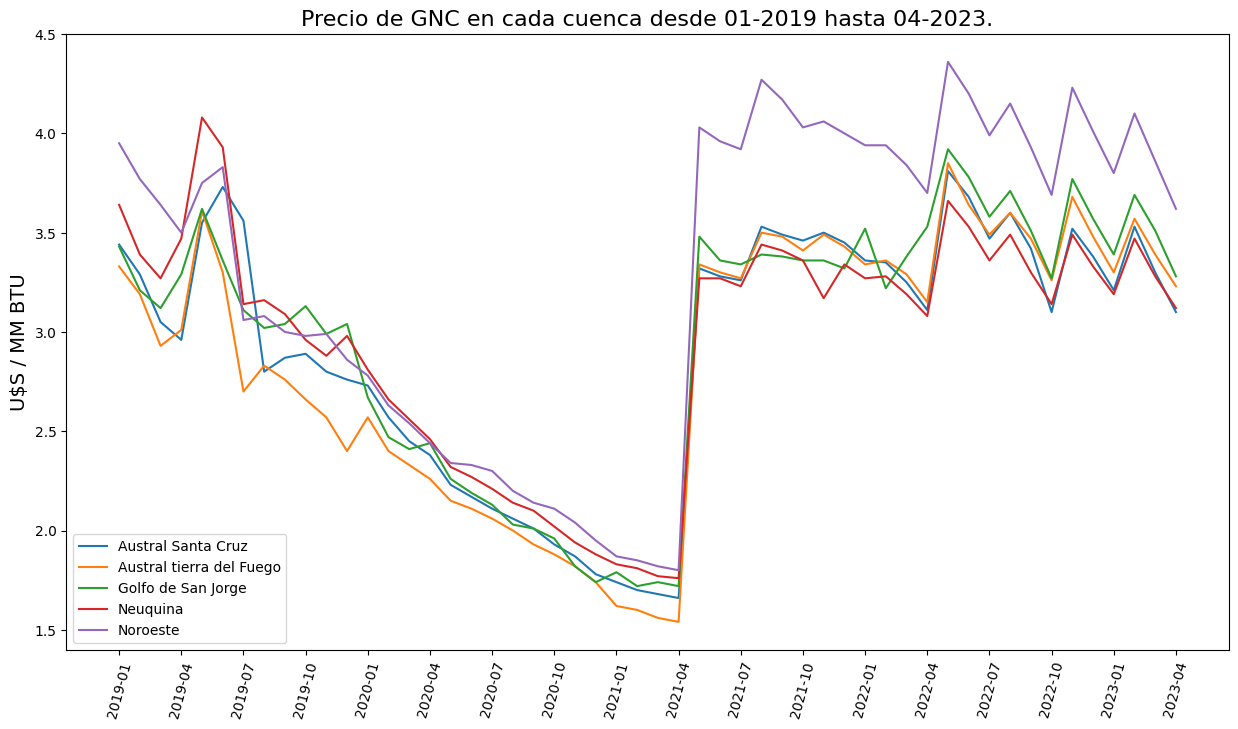

In [76]:
plt.figure(figsize=(15, 8))

for cuenca in cuencas:
    plt.plot(
        cuenca.indice_tiempo,
        cuenca.precio_gnc,
        label=cuenca.Name
    )

plt.xticks(np.arange(0, 52, 3), rotation=75)
plt.title(
    'Precio de GNC en cada cuenca desde 01-2019 hasta 04-2023.',
    fontsize=16
)

plt.ylabel(
    'U$S / MM BTU',
    fontsize=14
)

plt.legend()

In [53]:
exportaciones_promedio = []

for cuenca in cuencas:
    exportaciones_promedio.append(
        (
            cuenca.Name,
            round(cuenca.precio_expo.mean(), 2)
        )
    )
    
exportaciones_promedio.sort(key=lambda tupla: tupla[1], reverse=True)

Precio promedio para la exportación de cada cuenca:

In [77]:
for val in exportaciones_promedio:
    print(f'{val[0]:<25} {val[1]}')

Neuquina                  4.59
Austral Santa Cruz        2.52
Austral tierra del Fuego  1.56
Golfo de San Jorge        0.88
Noroeste                  0.14


Naturalmente la cuenca Neuquina tiene el mayor precio para las exportación ya que ahí se encuentra Vaca Muerta.

Text(0.5, 1.0, 'Relación entre el precio de GNC y el precio de exportación')

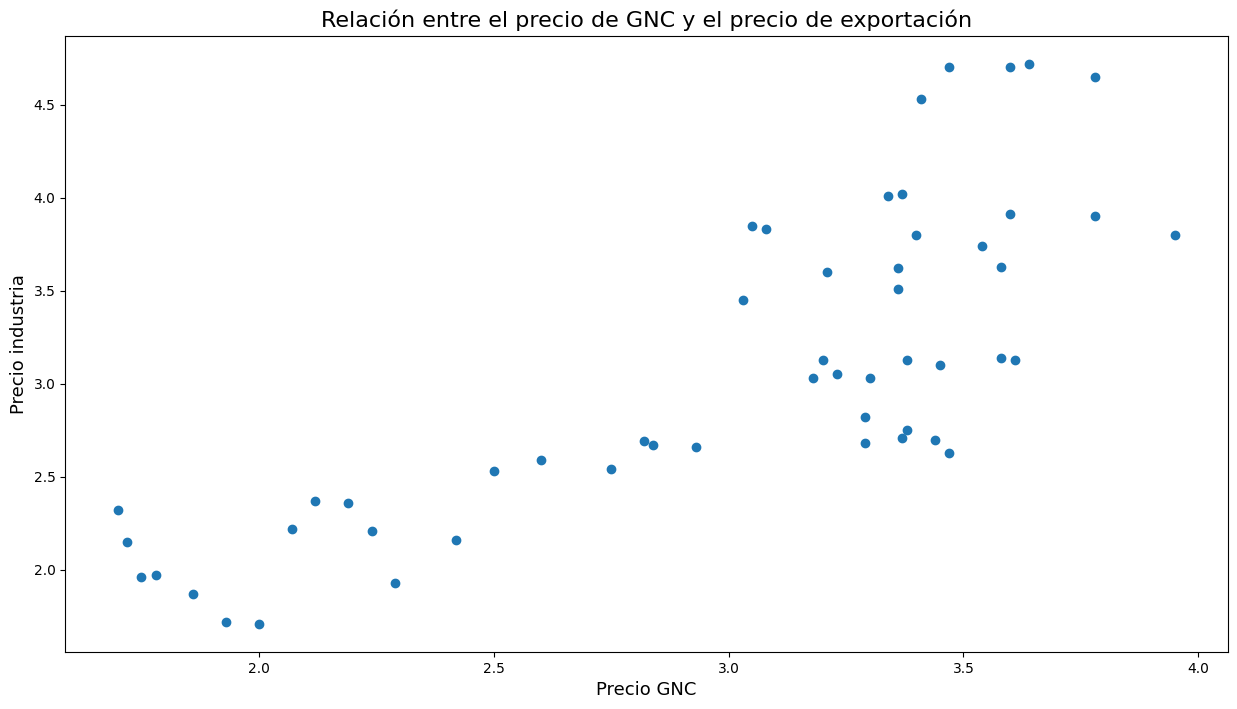

In [82]:
plt.figure(figsize=(15, 8))

plt.scatter(cuencas_total.precio_gnc,
            cuencas_total.precio_industria)

plt.xlabel(
    'Precio GNC',
    fontsize=13
)

plt.ylabel(
    'Precio industria',
    fontsize=13
)

plt.title(
    'Relación entre el precio de GNC y el precio de exportación',
    fontsize=16
)

Podemos ver en el gráfico que hay una correlación entre el precio de GNC y el precio de venta a la industria. Tiene sentido que esto sea así porque ademas de los gastos de industria las empresas también tienen los gastos de transporte para la logística.

In [9]:
precios_materiales.anio = precios_materiales.anio.astype(str)
precios_materiales.mes = precios_materiales.mes.astype(str)

In [10]:
precios_materiales['indice_tiempo'] = \
    precios_materiales.anio + '-' + precios_materiales.mes.str.zfill(2)

In [12]:
id_rubros = precios_materiales.id_rubro.unique()

In [13]:
porcentajes = list()

for rubro in id_rubros:
    precio_inicial = \
        precios_materiales[precios_materiales.id_rubro == rubro].iloc[0].indice
    
    precio_final = \
        precios_materiales[precios_materiales.id_rubro == rubro].iloc[-1].indice
    
    nombre_material = \
        precios_materiales[precios_materiales.id_rubro == rubro].iloc[0].rubro
    
    rango = precio_final - precio_inicial
    
    porcentajes.append((nombre_material, round((rango / precio_inicial) * 100, 2)))

In [14]:
porcentajes.sort(key=lambda tupla: tupla[1])

Text(0, 0.5, 'Aumento de precio en %')

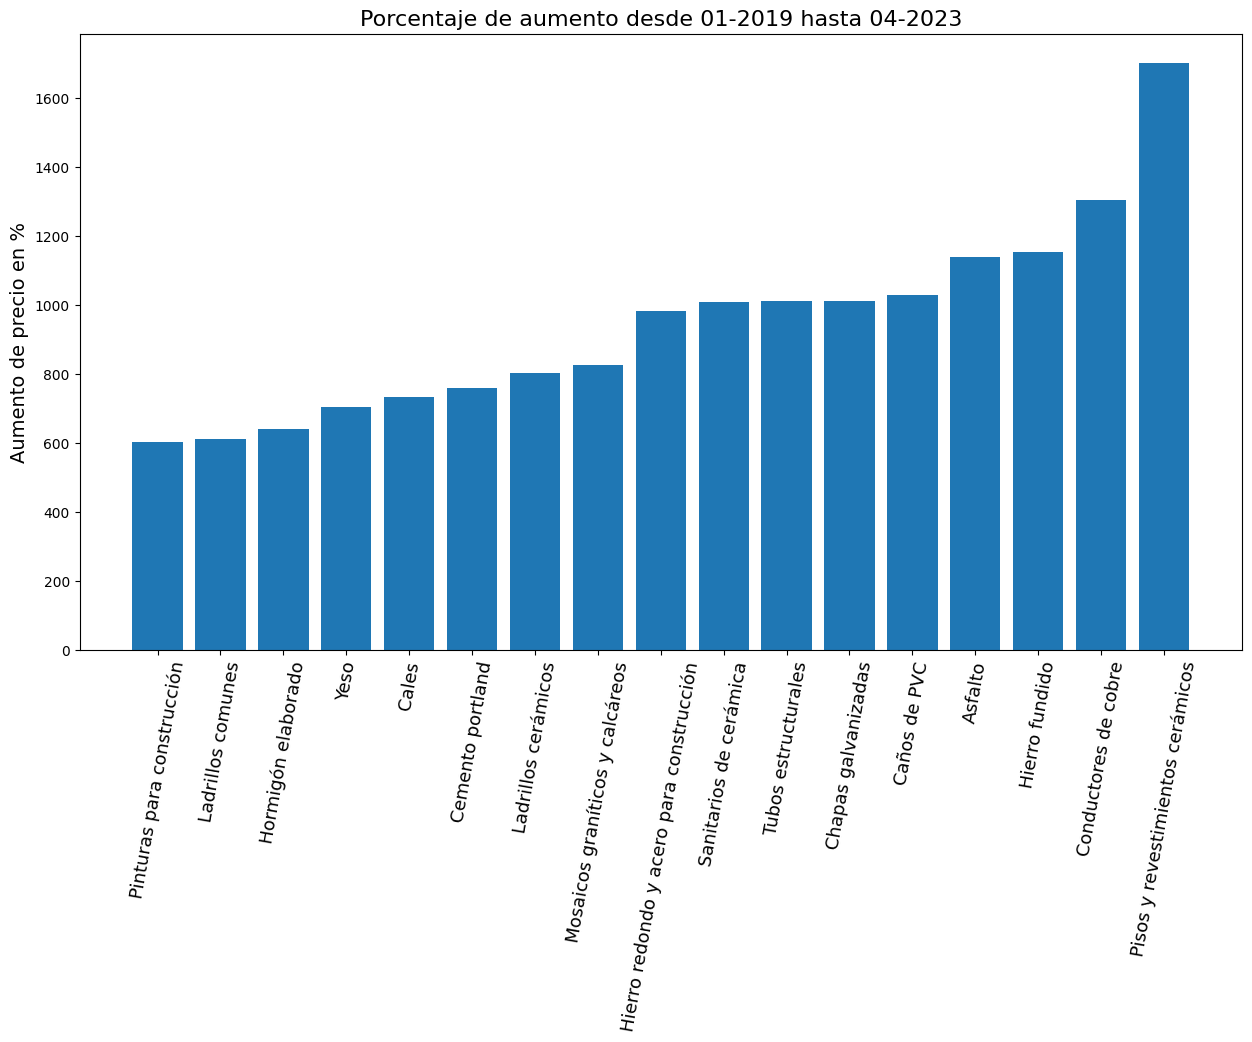

In [15]:
plt.figure(figsize=(15, 8))

plt.bar(
    [tupla[0] for tupla in porcentajes],
    [tupla[1] for tupla in porcentajes]
)

plt.xticks(
    rotation=80,
    fontsize=13
)

plt.title(
    'Porcentaje de aumento desde 01-2019 hasta 04-2023',
    fontsize=16
)

plt.ylabel('Aumento de precio en %', fontsize=14)

Es interesante ver que los pisos y revestimientos cerámicos tuvieron el aumento más grande de todos. Las otras categorías también tuvieron un gran aumento pero no hay un salto tan grande entre estos materiales.

In [18]:
cuencas_total = precios_gas[precios_gas.cuenca == 'Total Cuenca']

In [21]:
cuencas_total.head(2)

,id_pub,anio,mes,cuenca,contrato,precio_distribuidora,precio_gnc,precio_usina,precio_industria,precio_otros,precio_ppp,precio_expo,indice_tiempo
17,18,2019,1,Total Cuenca,TOTAL,3.80,3.58,2.92,3.63,3.74,3.37,3.92,2019-01
35,36,2019,2,Total Cuenca,TOTAL,3.83,3.36,2.63,3.62,3.43,3.22,4.44,2019-02
53,54,2019,3,Total Cuenca,TOTAL,3.77,3.21,2.61,3.60,3.35,3.27,4.07,2019-03


## Unión de los datasets

In [155]:
precios = \
    pd.merge(
        left=precios_gas,
        right=precios_materiales,
        how='inner',
        left_on='indice_tiempo',
        right_on='indice_tiempo'
    )

In [156]:
precios.drop(
    columns={
        'anio_x',
        'mes_x',
        'anio_y',
        'mes_y'
    },
    inplace=True
)

In [205]:
precios.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5304 entries, 0 to 5303
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id_pub                5304 non-null   int64  
 1   cuenca                5304 non-null   object 
 2   contrato              5304 non-null   object 
 3   precio_distribuidora  5304 non-null   float64
 4   precio_gnc            5304 non-null   float64
 5   precio_usina          5304 non-null   float64
 6   precio_industria      5304 non-null   float64
 7   precio_otros          5304 non-null   float64
 8   precio_ppp            5304 non-null   float64
 9   precio_expo           5304 non-null   float64
 10  indice_tiempo         5304 non-null   object 
 11  id_rubro              5304 non-null   int64  
 12  rubro                 5304 non-null   object 
 13  indice                5304 non-null   float64
 14  variacion_mensual     5304 non-null   float64
dtypes: float64(9), int64(